In [1]:
#Installations, Authentication, and Llama Model Loading
!pip install transformers accelerate bitsandbytes torch datasets scikit-learn matplotlib seaborn umap-learn huggingface_hub

In [2]:
import torch
from transformers import AutoTokenizer, AutoModelForCausalLM, BitsAndBytesConfig, pipeline as hf_pipeline
from datasets import load_dataset
import numpy as np
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
import umap
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt
import seaborn as sns
from huggingface_hub import login, HfFolder

# --- User Configuration ---
MODEL_NAME = "meta-llama/Meta-Llama-3-8B-Instruct"
use_quantization = True

# --- Hugging Face Token ---
print("Attempting Hugging Face login...")
try:
    if HfFolder.get_token() is None:
        print("Hugging Face token not found in cache. Please log in when prompted.")
        login()
        print("Login successful (or token was already cached and valid).")
    else:
        print(f"Hugging Face token found in cache: {HfFolder.get_token()[:10]}... (masked)")
except Exception as e:
    print(f"Error during Hugging Face login attempt: {e}"); raise

# --- Device Configuration ---
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")
if device.type == 'cpu': print("WARNING: Running on CPU will be very slow.")

# --- Load Tokenizer and Model ---
print(f"Loading tokenizer for '{MODEL_NAME}'..."); tokenizer = AutoTokenizer.from_pretrained(MODEL_NAME); print("Tokenizer loaded.")
print(f"Loading model '{MODEL_NAME}'...")
if use_quantization:
    bnb_config = BitsAndBytesConfig(load_in_4bit=True, bnb_4bit_quant_type="nf4", bnb_4bit_use_double_quant=True, bnb_4bit_compute_dtype=torch.bfloat16)
    model = AutoModelForCausalLM.from_pretrained(MODEL_NAME, quantization_config=bnb_config, device_map="auto", torch_dtype=torch.bfloat16)
    print(f"Model '{MODEL_NAME}' loaded with 4-bit quantization.")
else:
    model = AutoModelForCausalLM.from_pretrained(MODEL_NAME, device_map="auto", torch_dtype=torch.bfloat16)
    print(f"Model '{MODEL_NAME}' loaded without quantization.")

if tokenizer.pad_token is None:
    if tokenizer.eos_token is not None:
        tokenizer.pad_token = tokenizer.eos_token
        if hasattr(model, 'config') and model.config.pad_token_id is None: model.config.pad_token_id = tokenizer.pad_token_id
        print(f"Set pad_token to eos_token: {tokenizer.pad_token} (ID: {tokenizer.pad_token_id})")
    else:
        tokenizer.add_special_tokens({'pad_token': '[PAD]'}); model.resize_token_embeddings(len(tokenizer))
        if hasattr(model, 'config'): model.config.pad_token_id = tokenizer.pad_token_id
        print(f"Added new pad_token: {tokenizer.pad_token} (ID: {tokenizer.pad_token_id})")
print("Setup Complete.")

Attempting Hugging Face login...
Hugging Face token found in cache: hf_CNJZIjg... (masked)
Using device: cuda
Loading tokenizer for 'meta-llama/Meta-Llama-3-8B-Instruct'...
Tokenizer loaded.
Loading model 'meta-llama/Meta-Llama-3-8B-Instruct'...


config.json:   0%|          | 0.00/654 [00:00<?, ?B/s]

model.safetensors.index.json:   0%|          | 0.00/23.9k [00:00<?, ?B/s]

Fetching 4 files:   0%|          | 0/4 [00:00<?, ?it/s]

model-00004-of-00004.safetensors:   0%|          | 0.00/1.17G [00:00<?, ?B/s]

model-00003-of-00004.safetensors:   0%|          | 0.00/4.92G [00:00<?, ?B/s]

model-00001-of-00004.safetensors:   0%|          | 0.00/4.98G [00:00<?, ?B/s]

model-00002-of-00004.safetensors:   0%|          | 0.00/5.00G [00:00<?, ?B/s]

Loading checkpoint shards:   0%|          | 0/4 [00:00<?, ?it/s]

generation_config.json:   0%|          | 0.00/187 [00:00<?, ?B/s]

Model 'meta-llama/Meta-Llama-3-8B-Instruct' loaded with 4-bit quantization.
Set pad_token to eos_token: <|eot_id|> (ID: 128009)
Setup Complete.


In [4]:
#Define Concept and Prepare Data
CONCEPT_NAME = "sentiment"
positive_texts = ["This is a wonderful experience and I am very happy.", "I love this product, it's absolutely fantastic!", "The weather is beautiful today, perfect for a walk.", "She gave a truly inspiring and uplifting speech.", "What a delightful surprise, it made my day!"]
negative_texts = ["This is a terrible situation and I am very upset.", "I hate this product, it's absolutely awful!", "The weather is miserable today, dreadful for any activity.", "His comments were deeply frustrating and disheartening.", "What a horrible incident, it ruined everything."]
print(f"Concept for v_C: {CONCEPT_NAME}, {len(positive_texts)} pos / {len(negative_texts)} neg examples.")

Concept for v_C: sentiment, 5 pos / 5 neg examples.


Targeting module for v_C ACTIVATION EXTRACTION: LlamaDecoderLayer
Registered extraction hook on last_decoder_block_output_for_vc.
Using token aggregation strategy: -1 for v_C activation extraction.
Activations for v_C extracted. Pos shape: torch.Size([5, 4096]), Neg shape: torch.Size([5, 4096])

Training Linear Probe for Concept Vector...
Linear probe trained. Training accuracy: 100.00%
Concept vector from PROBE calculated. Shape: torch.Size([4096])
v_C Activation extraction hook removed.

Running PCA...


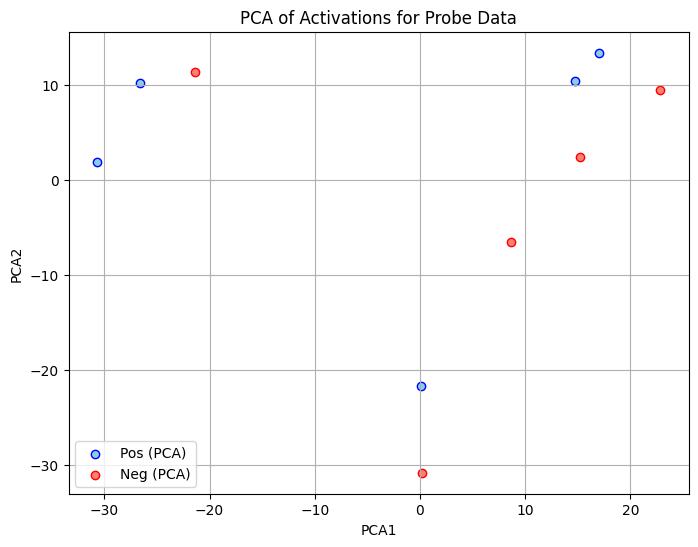

In [5]:
#Activation Extraction, Concept Vector (FROM PROBE - Iteration 2 method), and FULL Visualizations

activations_storage = {}
def get_activation_hook(layer_name_in_storage):
    def hook(model_module, M_input, M_output):
        activations_storage[layer_name_in_storage] = (M_output[0] if isinstance(M_output, tuple) else M_output).detach()
    return hook

target_module_for_extraction = None; hook_handle_extraction = None
extraction_hook_storage_name = "last_decoder_block_output_for_vc" # Specific name for v_C extraction

try:
    # For v_C calculation, we consistently extract from the last layer for now
    target_module_for_extraction = model.model.layers[-1]
    print(f"Targeting module for v_C ACTIVATION EXTRACTION: {type(target_module_for_extraction).__name__}")
except Exception as e: print(f"Error accessing extraction layer: {e}")

if target_module_for_extraction:
    if 'hook_handle_extraction' in globals() and hook_handle_extraction is not None:
        try: hook_handle_extraction.remove(); print("Removed pre-existing extraction hook.")
        except: pass
    hook_handle_extraction = target_module_for_extraction.register_forward_hook(get_activation_hook(extraction_hook_storage_name))
    print(f"Registered extraction hook on {extraction_hook_storage_name}.")
else: print("Skipping extraction hook registration.")

def get_activations_for_texts_batch(texts_batch, storage_name, agg_token_strategy=-1): # Renamed storage_name
    inputs = tokenizer(texts_batch, return_tensors="pt", padding=True, truncation=True, max_length=128).to(device)
    if storage_name in activations_storage: del activations_storage[storage_name]
    with torch.no_grad(): _ = model(**inputs)
    batch_activations = activations_storage.get(storage_name)
    if batch_activations is None: raise ValueError(f"Activations not found: '{storage_name}'. Hook issue?")
    batch_activations_cpu = batch_activations.cpu()
    if agg_token_strategy == 'mean': return batch_activations_cpu.mean(dim=1)
    elif agg_token_strategy == -1:
        seq_lens = inputs.attention_mask.sum(dim=1)
        return torch.stack([batch_activations_cpu[i, max(0, seq_lens[i].item()-1), :] for i in range(batch_activations_cpu.shape[0])])
    else: return batch_activations_cpu[:, agg_token_strategy, :]

concept_vector_sentiment = None; positive_activations, negative_activations = None, None

if hook_handle_extraction and target_module_for_extraction:
    token_aggregation_strategy = -1
    print(f"Using token aggregation strategy: {token_aggregation_strategy} for v_C activation extraction.")
    try:
        positive_activations = get_activations_for_texts_batch(positive_texts, extraction_hook_storage_name, token_aggregation_strategy)
        negative_activations = get_activations_for_texts_batch(negative_texts, extraction_hook_storage_name, token_aggregation_strategy)
        print(f"Activations for v_C extracted. Pos shape: {positive_activations.shape}, Neg shape: {negative_activations.shape}")

        print("\nTraining Linear Probe for Concept Vector...")
        from sklearn.linear_model import LogisticRegression
        from sklearn.preprocessing import StandardScaler
        all_acts_for_probe_torch = torch.cat([positive_activations, negative_activations], dim=0)
        all_acts_for_probe_numpy = all_acts_for_probe_torch.to(torch.float32).numpy()
        probe_labels = np.array([1]*len(positive_activations) + [0]*len(negative_activations))
        scaler = StandardScaler(); all_acts_scaled = scaler.fit_transform(all_acts_for_probe_numpy)
        probe_classifier = LogisticRegression(solver='liblinear', C=0.1, class_weight='balanced', random_state=42)
        probe_classifier.fit(all_acts_scaled, probe_labels)
        accuracy = probe_classifier.score(all_acts_scaled, probe_labels)
        print(f"Linear probe trained. Training accuracy: {accuracy*100:.2f}%")
        probe_weights = probe_classifier.coef_[0]
        concept_vector_sentiment = torch.tensor(probe_weights, dtype=torch.bfloat16).to(device)
        # Optional: concept_vector_sentiment = concept_vector_sentiment / torch.norm(concept_vector_sentiment)
        print(f"Concept vector from PROBE calculated. Shape: {concept_vector_sentiment.shape}")
    except Exception as e: print(f"Error during activation extraction or probe training for v_C: {e}")
    finally:
        if hook_handle_extraction: hook_handle_extraction.remove(); print("v_C Activation extraction hook removed.")

    if positive_activations is not None and negative_activations is not None:
        all_extracted_activations_float32 = torch.cat([positive_activations, negative_activations], dim=0).to(torch.float32)
        all_extracted_activations_numpy = all_extracted_activations_float32.numpy()
        n_positive = len(positive_texts)
        print("\nRunning PCA..."); pca = PCA(n_components=2); projected_pca = pca.fit_transform(all_extracted_activations_numpy); plt.figure(figsize=(8,6)); plt.scatter(projected_pca[:n_positive,0], projected_pca[:n_positive,1],label="Pos (PCA)",c="skyblue",edgecolors='b'); plt.scatter(projected_pca[n_positive:,0], projected_pca[n_positive:,1],label="Neg (PCA)",c="salmon",edgecolors='r'); plt.xlabel("PCA1");plt.ylabel("PCA2"); plt.title("PCA of Activations for Probe Data"); plt.legend(); plt.grid(True); plt.show()
        # Add other visualizations (t-SNE, UMAP, K-Means, Heatmaps) here if desired, using all_extracted_activations_numpy
else:
    print("Initial hook setup for v_C extraction failed. Concept vector cannot be calculated.")

In [6]:
#Evaluation Setup & Test Prompts

test_prompts_base = ["The report covered several key areas of the project", "During the weekly meeting, the team discussed", "The system update is scheduled to deploy", "Feedback from the initial user testing indicated", "Further analysis of the data revealed that"]
try:
    sentiment_classifier_pipe = hf_pipeline("sentiment-analysis", device=0 if torch.cuda.is_available() else -1)
    print("Sentiment classifier pipeline loaded.")
except Exception as e: print(f"Error loading sentiment classifier: {e}"); sentiment_classifier_pipe = None

def score_concept_control(generated_texts, target_sentiment_label="POSITIVE", target_score_threshold=0.7):
    if not generated_texts or sentiment_classifier_pipe is None: return 0.0
    valid_texts = [t for t in generated_texts if isinstance(t, str) and t.strip()]
    if not valid_texts: return 0.0
    sentiments = sentiment_classifier_pipe(valid_texts)
    controlled_count = sum(1 for r in sentiments if r['label'].upper() == target_sentiment_label.upper() and r['score'] > target_score_threshold)
    return (controlled_count / len(valid_texts)) * 100 if valid_texts else 0.0

ppl_model, ppl_tokenizer = None, None
try:
    ppl_model_name = "gpt2"; print(f"Loading PPL model: {ppl_model_name}...")
    ppl_tokenizer = AutoTokenizer.from_pretrained(ppl_model_name)
    ppl_model = AutoModelForCausalLM.from_pretrained(ppl_model_name).to(device)
    if ppl_tokenizer.pad_token is None: ppl_tokenizer.pad_token = ppl_tokenizer.eos_token
    print(f"PPL model '{ppl_model_name}' loaded.")
except Exception as e: print(f"Error loading PPL model: {e}")

def calculate_perplexity(texts_list):
    if not texts_list or ppl_model is None: return float('inf')
    total_nll, total_tokens, valid_texts_count = 0, 0, 0
    for text_item in texts_list:
        if not isinstance(text_item, str) or not text_item.strip(): continue
        max_len = ppl_tokenizer.model_max_length if ppl_tokenizer.model_max_length < 10000 else 1024
        encodings = ppl_tokenizer(text_item,return_tensors="pt",padding=True,truncation=True,max_length=max_len).to(device)
        if encodings.input_ids.numel() == 0: continue
        valid_texts_count += 1
        with torch.no_grad(): outputs = ppl_model(encodings.input_ids, labels=encodings.input_ids)
        total_nll += outputs.loss.item() * encodings.input_ids.size(1)
        total_tokens += encodings.input_ids.size(1)
    if total_tokens == 0: return float('inf')
    return torch.exp(torch.tensor(total_nll / total_tokens)).item()
print("Evaluation functions and test_prompts_base defined.")

No model was supplied, defaulted to distilbert/distilbert-base-uncased-finetuned-sst-2-english and revision 714eb0f (https://huggingface.co/distilbert/distilbert-base-uncased-finetuned-sst-2-english).
Using a pipeline without specifying a model name and revision in production is not recommended.


config.json:   0%|          | 0.00/629 [00:00<?, ?B/s]

Xet Storage is enabled for this repo, but the 'hf_xet' package is not installed. Falling back to regular HTTP download. For better performance, install the package with: `pip install huggingface_hub[hf_xet]` or `pip install hf_xet`


model.safetensors:   0%|          | 0.00/268M [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

Device set to use cuda:0


Sentiment classifier pipeline loaded.
Loading PPL model: gpt2...


tokenizer_config.json:   0%|          | 0.00/26.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/665 [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/1.04M [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/456k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.36M [00:00<?, ?B/s]

Xet Storage is enabled for this repo, but the 'hf_xet' package is not installed. Falling back to regular HTTP download. For better performance, install the package with: `pip install huggingface_hub[hf_xet]` or `pip install hf_xet`


model.safetensors:   0%|          | 0.00/548M [00:00<?, ?B/s]

generation_config.json:   0%|          | 0.00/124 [00:00<?, ?B/s]

PPL model 'gpt2' loaded.
Evaluation functions and test_prompts_base defined.


In [7]:
#MODIFIED for Iteration 3 - Steering Layer & Alpha Tuning

if 'concept_vector_sentiment' not in globals() or concept_vector_sentiment is None:
    print("ERROR: `concept_vector_sentiment` (probe-derived) is not defined from Cell 3. Cannot run Iteration 3.")
else:
    print(f"Proceeding with Iteration 3 using probe-derived concept_vector_sentiment. Shape: {concept_vector_sentiment.shape}")

    # --- Iteration 3 Configuration ---
    # Layers to test for applying the steering intervention (indices from the end of model.model.layers)
    # Llama 3 8B has 32 layers (0 to 31). -1 is layer 31, -2 is layer 30, etc.
    layers_to_steer_indices = [-1, -3, -5, -8, -12] # Example layers to test

    # Alphas for positive steering (based on Iteration 2.1 findings)
    alphas_for_positive_steering = [0.5, 1.0]
    # Fixed alpha for negative steering (worked well in Iteration 2.1)
    alpha_for_negative_steering = -1.0

    max_new_gen_tokens = 40
    tokenizer_input_max_len = 512
    steering_hook_storage_name = "dynamic_steering_hook_output" # Name for hook storage (if used)

    iteration_results_i3 = {} # Store results for Iteration 3

    # --- Steering Hook Function (same as before) ---
    def steering_hook_fn_i3(layer_name_in_storage, concept_vector_to_add, alpha_value, steer_token_idx=-1):
        def hook(module, M_input, M_output):
            original_output_tensor = M_output[0] if isinstance(M_output, tuple) else M_output
            modified_output_tensor = original_output_tensor.clone()
            cv_on_correct_device = concept_vector_to_add.to(modified_output_tensor.device, dtype=modified_output_tensor.dtype)
            if steer_token_idx == -1:
                modified_output_tensor[:, -1:, :] = modified_output_tensor[:, -1:, :] + (alpha_value * cv_on_correct_device.unsqueeze(0))
            # ... (other steering options if needed, e.g., steer_token_idx is None) ...
            if isinstance(M_output, tuple): return (modified_output_tensor,) + M_output[1:]
            else: return modified_output_tensor
        return hook

    # --- Generate and Evaluate Function (modified slightly for Iteration 3 logging) ---
    def generate_and_evaluate_i3(current_run_name, prompts_base_list, steering_module_for_hook,
                                 apply_steering=False, concept_vec=None,
                                 alpha_val=0, target_sentiment_for_ccs=None):
        generated_texts_for_eval = []
        hook_handle_steering_i3 = None
        if apply_steering and steering_module_for_hook and concept_vec is not None:
            steering_hook_instance = steering_hook_fn_i3(steering_hook_storage_name, concept_vec, alpha_val, steer_token_idx=-1)
            hook_handle_steering_i3 = steering_module_for_hook.register_forward_hook(steering_hook_instance)
            print(f"\nGenerating texts for '{current_run_name}' (Steering Layer: {steering_module_for_hook.__class__.__name__}, Alpha: {alpha_val:.2f})...")
        else:
            print(f"\nGenerating texts for '{current_run_name}' (No steering / Baseline)...")

        for p_base in prompts_base_list:
            messages = [{"role": "system", "content": "You are a helpful assistant."}, {"role": "user", "content": f"{p_base}, and in summary, the general feeling was"}]
            prompt_string = tokenizer.apply_chat_template(messages, tokenize=False, add_generation_prompt=True)
            inputs = tokenizer(prompt_string, return_tensors="pt", max_length=tokenizer_input_max_len, truncation=True).to(device)
            if inputs.input_ids.shape[1] == 0: generated_texts_for_eval.append(""); continue
            try:
                with torch.no_grad():
                    outputs = model.generate(inputs.input_ids, attention_mask=inputs.attention_mask, max_new_tokens=max_new_gen_tokens,
                                             temperature=0.7, do_sample=True, pad_token_id=tokenizer.pad_token_id, eos_token_id=tokenizer.eos_token_id)
                full_decoded_text = tokenizer.decode(outputs[0], skip_special_tokens=True)
                input_len = inputs.input_ids.shape[1]; completion_only = tokenizer.decode(outputs[0, input_len:], skip_special_tokens=True)
                print(f"  Prompt: '{p_base[:50]}...' -> Completion: '{completion_only[:100]}...'")
                generated_texts_for_eval.append(full_decoded_text)
            except Exception as e: print(f"  Error: {e}"); generated_texts_for_eval.append("")
        if hook_handle_steering_i3: hook_handle_steering_i3.remove()

        current_ppl = calculate_perplexity(generated_texts_for_eval)
        current_ccs = 0.0
        if target_sentiment_for_ccs and generated_texts_for_eval:
            current_ccs = score_concept_control(generated_texts_for_eval, target_sentiment_for_ccs)

        iteration_results_i3[current_run_name] = {"ppl": current_ppl, "ccs": current_ccs if target_sentiment_for_ccs else "N/A", "outputs": generated_texts_for_eval, "alpha": alpha_val, "steering_layer_idx": steering_module_for_hook.layer_idx if hasattr(steering_module_for_hook, 'layer_idx') else 'N/A'}
        print(f"Results for '{current_run_name}': PPL: {current_ppl:.2f}", end="")
        if target_sentiment_for_ccs: print(f", CCS ({target_sentiment_for_ccs}): {current_ccs:.2f}%")
        else: print("")
        return generated_texts_for_eval

    # --- Main Execution for Iteration 3 ---
    if hasattr(model, 'model') and hasattr(model.model, 'layers') and ('concept_vector_sentiment' in globals() and concept_vector_sentiment is not None):
        print("\n--- Iteration 3: Optimizing Steering Layer & Alpha (using Probe $v_C$) ---")

        # 1. Baseline (Optional: run once or use previous baseline PPL from Iteration 2.1 summary)
        # generate_and_evaluate_i3("baseline_i3", test_prompts_base, steering_module_for_hook=None, apply_steering=False)
        print(f"Reference Baseline PPL (from Iteration 2.1 summary): ~65.07 (No steering, probe $v_C$ not applied)")


        for layer_idx_from_end in layers_to_steer_indices:
            actual_layer_index = len(model.model.layers) + layer_idx_from_end if layer_idx_from_end < 0 else layer_idx_from_end
            if not (0 <= actual_layer_index < len(model.model.layers)):
                print(f"Skipping invalid layer index: {layer_idx_from_end} (actual: {actual_layer_index})")
                continue

            current_steering_module = model.model.layers[actual_layer_index]
            # Add layer_idx attribute for logging if it doesn't exist (HuggingFace Llama layers don't have it by default)
            current_steering_module.layer_idx = actual_layer_index # For logging purposes

            print(f"\n----- Testing Steering on Layer: {actual_layer_index} ({layer_idx_from_end} from end) -----")

            # Positive Steering with different alphas
            for alpha_pos in alphas_for_positive_steering:
                generate_and_evaluate_i3(
                    current_run_name=f"L{actual_layer_index}_pos_steer_alpha_{alpha_pos:.1f}",
                    prompts_base_list=test_prompts_base,
                    steering_module_for_hook=current_steering_module,
                    apply_steering=True,
                    concept_vec=concept_vector_sentiment, # Probe_vc
                    alpha_val=alpha_pos,
                    target_sentiment_for_ccs="POSITIVE"
                )

            # Negative Steering with fixed alpha
            generate_and_evaluate_i3(
                current_run_name=f"L{actual_layer_index}_neg_steer_alpha_{alpha_for_negative_steering:.1f}",
                prompts_base_list=test_prompts_base,
                steering_module_for_hook=current_steering_module,
                apply_steering=True,
                concept_vec=concept_vector_sentiment, # Probe_vc
                alpha_val=alpha_for_negative_steering,
                target_sentiment_for_ccs="NEGATIVE"
            )

        print("\n--- Iteration 3 Evaluation Complete ---")
        print("\nSummary of Iteration 3 Results (Probe $v_C$, Varying Steering Layer & Alpha):")
        for run_name, metrics in iteration_results_i3.items():
            layer_info = metrics.get('steering_layer_idx', 'N/A')
            print(f"  Run: {run_name}, SteeringLayerIdx: {layer_info}, Alpha: {metrics.get('alpha', 'N/A'):.1f}, PPL: {metrics.get('ppl', 'N/A'):.2f}, CCS: {metrics.get('ccs', 'N/A')}")
    else:
        print("Skipping Iteration 3 due to missing 'model.model.layers', or 'concept_vector_sentiment' (probe-derived).")

Proceeding with Iteration 3 using probe-derived concept_vector_sentiment. Shape: torch.Size([4096])

--- Iteration 3: Optimizing Steering Layer & Alpha (using Probe $v_C$) ---
Reference Baseline PPL (from Iteration 2.1 summary): ~65.07 (No steering, probe $v_C$ not applied)

----- Testing Steering on Layer: 31 (-1 from end) -----

Generating texts for 'L31_pos_steer_alpha_0.5' (Steering Layer: LlamaDecoderLayer, Alpha: 0.50)...
  Prompt: 'The report covered several key areas of the projec...' -> Completion: 'It sounds like you're summarizing a report. Would you like to share more about what the report cover...'
  Prompt: 'During the weekly meeting, the team discussed...' -> Completion: 'It sounds like the team had a productive meeting and was able to discuss and summarize the general f...'
  Prompt: 'The system update is scheduled to deploy...' -> Completion: 'Excitement and anticipation! The system update is finally here, and everyone is eager to see the new...'
  Prompt: 'Feedback fr

`loss_type=None` was set in the config but it is unrecognised.Using the default loss: `ForCausalLMLoss`.


  Prompt: 'Further analysis of the data revealed that...' -> Completion: 'I'd be happy to help you with that! It sounds like you've gathered some interesting insights from yo...'
Results for 'L31_pos_steer_alpha_0.5': PPL: 40.88, CCS (POSITIVE): 80.00%

Generating texts for 'L31_pos_steer_alpha_1.0' (Steering Layer: LlamaDecoderLayer, Alpha: 1.00)...
  Prompt: 'The report covered several key areas of the projec...' -> Completion: 'I'd be happy to help you with that! Please go ahead and share the report's summary, and I'll assist ...'
  Prompt: 'During the weekly meeting, the team discussed...' -> Completion: 'Please go ahead and share the summary of the weekly meeting. I'll help you summarize it in a concise...'
  Prompt: 'The system update is scheduled to deploy...' -> Completion: 'The system update is finally happening! I'm here to help you with any questions or concerns you may ...'
  Prompt: 'Feedback from the initial user testing indicated...' -> Completion: 'Please go ahead and s

You seem to be using the pipelines sequentially on GPU. In order to maximize efficiency please use a dataset


  Prompt: 'Further analysis of the data revealed that...' -> Completion: 'It sounds like you've been analyzing some data and have some key findings to share! I'd love to hear...'
Results for 'L24_pos_steer_alpha_1.0': PPL: 40.21, CCS (POSITIVE): 40.00%

Generating texts for 'L24_neg_steer_alpha_-1.0' (Steering Layer: LlamaDecoderLayer, Alpha: -1.00)...
  Prompt: 'The report covered several key areas of the projec...' -> Completion: 'I'd be happy to help you complete the sentence!...'
  Prompt: 'During the weekly meeting, the team discussed...' -> Completion: 'I'd be happy to help you summarize the meeting discussion! Please go ahead and share the details, su...'
  Prompt: 'The system update is scheduled to deploy...' -> Completion: 'Excitement and anticipation! The system update is finally arriving, and everyone is eager to see the...'
  Prompt: 'Feedback from the initial user testing indicated...' -> Completion: 'Please go ahead and share the feedback from the initial user testing. I'